- Figure 4e : Normal OPC vs GFP(+) OPC
- Figure 4f : GFP (+) OPC vs GFP(+) Tumor
- Gene sets
  - GO : biological process
  - KEGG
  - REACTOME
  - MouseMine
- ORA -> GSEA

In [1]:
import os
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import pandas as pd
import decoupler as dc

import mplscience
import matplotlib.pyplot as plt

from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

seed = 777

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

In [2]:
# create pseudobulk & replicates
# condition : columns in adata.obs

def do_pseudobulk(adata, condition, contrast = None, seed = seed):
    print("*** Don't forget to set reference value for each category ***\n")
    
    
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) # 2-3 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            if contrast:
                if pd.api.types.is_numeric_dtype(sample_cell_subset.obs[contrast]):
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].mean()
                else:
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    design_factors = [x for x in [contrast, 'condition', ] if x is not None]
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = design_factors,
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return pb, dds, de, fig

In [3]:
msigdb = dc.get_resource('MSigDB', organism = 'mouse')

In [4]:
collections = msigdb['collection'].unique()
for idx, collection in enumerate(collections, 1):
    print(f"{idx}. {collection}")

# hallmark
# kegg_pathways
# go_biological_process
# reactome_pathways

## additional
# oncogenic_signatures
# cell_type_signatures = annotation?
# cancer_modules

1. chemical_and_genetic_perturbations
2. immunesigdb
3. mirna_targets_mirdb
4. go_molecular_function
5. tf_targets_gtrf
6. tf_targets_legacy
7. oncogenic_signatures
8. cell_type_signatures
9. vaccine_response
10. go_biological_process
11. cancer_gene_neighborhoods
12. cancer_modules
13. go_cellular_component
14. wikipathways
15. reactome_pathways
16. hallmark
17. mirna_targets_legacy
18. biocarta_pathways
19. positional
20. human_phenotype_ontology
21. pid_pathways
22. kegg_pathways


In [191]:
query = 'go_biological_process'
db = msigdb[msigdb['collection']==query]

db = db[~db.duplicated(['geneset', 'genesymbol'])]
db.dropna(inplace = True)

In [7]:
# mh_path = '/home/jiehoonk/mnt/annotations/GO/mh.all.v2023.2.Mm.symbols.gmt'
# mh_path = '/Users/jiehoonk/DevHub/mnt/annotations/GO/mh.all.v2023.2.Mm.symbols.gmt'

# def gmt_to_decoupler(path):
#     from itertools import chain, repeat
#     pathways = {}
    
#     with Path(path).open('r') as f:
#         for line in f:
#             name, _, *genes = line.strip().split('\t')
#             pathways[name] = genes
    
#     return pd.DataFrame.from_records(chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()), columns=['geneset', 'genesymbol'])

# hm = gmt_to_decoupler(mh_path)
# hm.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in hm.geneset]
# hm

# 1. Fig 4e

In [8]:
adata = sc.read_h5ad('../output/annotated_subcluster_embedding.h5ad')
adata = adata[adata.obs['cell_type'] == 'OPC'].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 14204 × 9829
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'each_cell_type_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
adata.obs['condition'] = adata.obs['sample_id'].apply(lambda x: 'Tumor' if x.startswith('Mouse') else 'Normal')

In [10]:
adata.obs.condition = adata.obs.condition.astype('category')

*** Don't forget to set reference value for each category ***



Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.43 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 0.42 seconds.

Fitting LFCs...
... done in 0.26 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 14 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs Normal
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik    70.741593        0.304765  0.198128  1.538223  1.239941e-01   
0610010K14Rik    86.750912        0.714388  0.192151  3.717849  2.009266e-04   
0610030E20Rik    39.725629        0.225517  0.081267  2.775000  5.520168e-03   
0610040J01Rik   215.201632       -1.385805  0.165116 -8.392917  4.742280e-17   
1110002L01Rik    19.285662        0.038860  0.132865  0.292481  7.699188e-01   
...                    ...             ...       ...       ...           ...   
mt-Nd3          516.205002       -1.159673  0.296547 -3.910592  9.207004e-05   
mt-Nd4         2893.283179       -0.446573  0.201798 -2.212968  2.689984e-02   
mt-Nd4l         245.533579       -1.659588  0.211144 -7.859997  3.841424e-15   
mt-Nd5          336.994769       -0.432704  0.111710 -3.873461  1.073005e-04   
mt-Nd6           51.012496       -0.026039  0.182234 -0.

... done in 0.26 seconds.



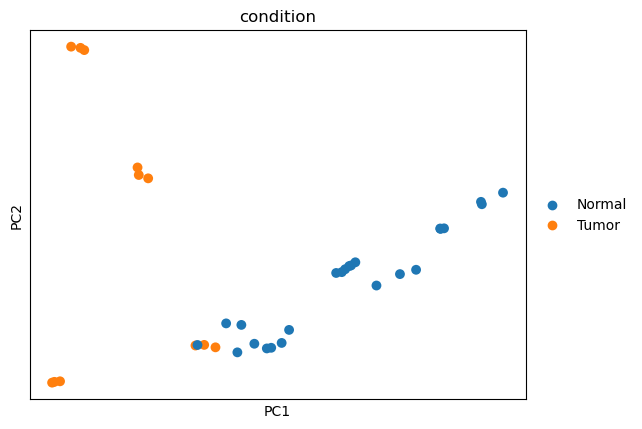

In [144]:
pb, dds, de, fig = do_pseudobulk(adata, 'condition')

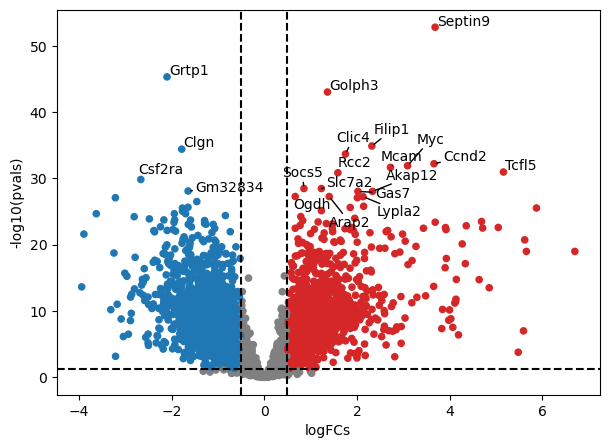

In [120]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20, )

## ORA

In [174]:
db['geneset'] = db['geneset'].apply(
    lambda x: x.split('_', 1)[1] if isinstance(x, str) and '_' in x else x
)

In [175]:
top_genes = de[de['padj'] < 0.05].copy()

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ABC_TRANSPORTERS,36,0.333333,0.513304,0.804756,1.057974,0.705550,Abca1;Abca3;Abca5;Abca6;Abca8b;Abcb4;Abcb8;Abc...
1,ACUTE_MYELOID_LEUKEMIA,40,0.450000,0.064384,0.207123,1.412183,3.873456,Akt1;Ccnd1;Kit;Kras;Mapk1;Mtor;Myc;Nfkb1;Pik3c...
2,ADHERENS_JUNCTION,54,0.388889,0.188496,0.458840,1.219308,2.034631,Actg1;Baiap2;Cdc42;Csnk2a1;Csnk2b;Ctnna1;Ctnnb...
3,ADIPOCYTOKINE_SIGNALING_PATHWAY,60,0.416667,0.082182,0.249240,1.303151,3.256343,Acsl1;Acsl3;Acsl4;Acsl5;Adipor1;Adipor2;Akt1;C...
4,ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,29,0.379310,0.322811,0.635320,1.204533,1.361951,Abat;Aldh4a1;Aldh5a1;Asl;Asns;Gad1;Gfpt2;Gls;G...


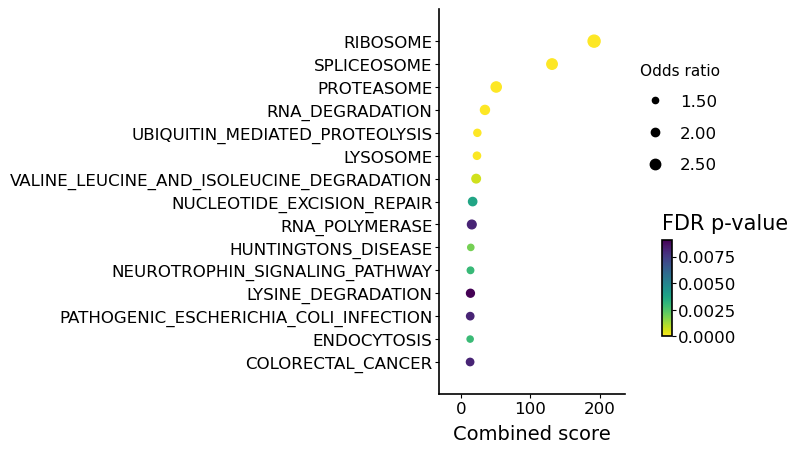

In [176]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
    )
    plt.grid(False)


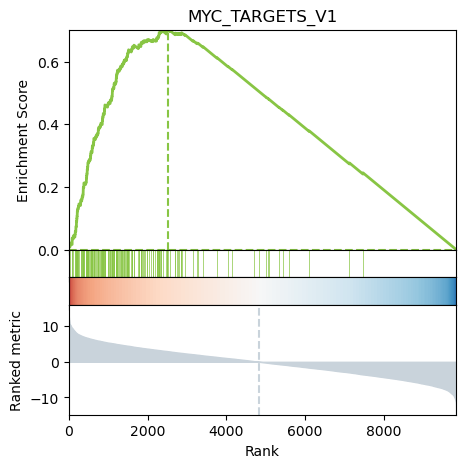

In [76]:
dc.plot_running_score(
    df=de,
    stat='stat',
    net=db,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)

## Progeny

In [149]:
progeny = dc.get_progeny(top=1000, organism = "mouse")
progeny

,source,target,weight,p_value
0,Androgen,Tmprss2,11.490631,0.000000e+00
1,Androgen,Nkx3-1,10.622551,2.242078e-44
2,Androgen,Mboat2,10.472733,4.624285e-44
3,Androgen,Sarg,11.386852,2.790209e-40
4,Androgen,Slc38a4,7.363805,1.253072e-39
...,...,...,...,...
13995,p53,Fanci,-3.962874,2.598821e-04
13996,p53,Ywhae,-1.924218,2.604428e-04
13997,p53,Elovl5,-1.287946,2.623710e-04
13998,p53,Naalad2,-1.035270,2.640760e-04


In [150]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

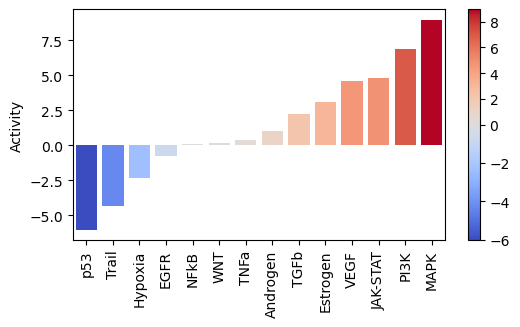

In [151]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

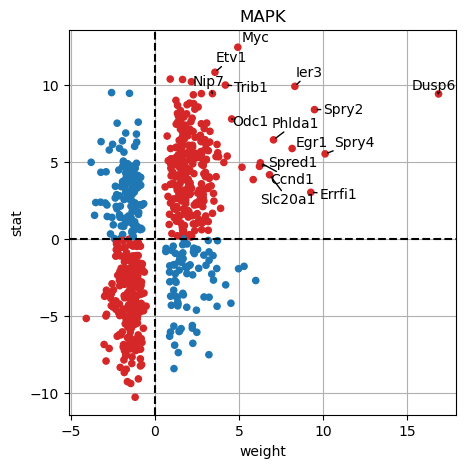

In [153]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='MAPK',
    net=progeny,
    top=15
)

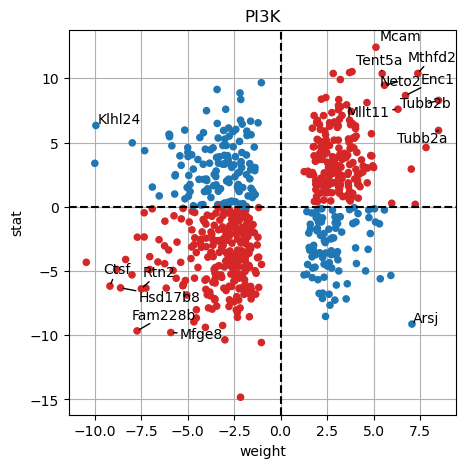

In [154]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='PI3K',
    net=progeny,
    top=15
)

# 2. Fig 4f

In [178]:
def do_pseudobulk(adata, condition, reference, seed = seed):
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) 
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0).reshape(1,-1),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['condition'],
        ref_level=['condition' ,reference],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

In [179]:
adata = sc.read_h5ad('../output/8_annotated_subcluster_embedding.h5ad')
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor'])].copy()
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4', 'Control'])].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 17722 × 10588
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'each_cell_type_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [180]:
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['OPC', 'Tumor'])

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.50 seconds.

Fitting dispersion trend curve...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 0.58 seconds.

Fitting LFCs...
... done in 0.33 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 1 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs OPC
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik   254.242389       -0.215308  0.261950 -0.821943  4.111094e-01   
0610010K14Rik   352.922694        0.185278  0.163766  1.131358  2.579044e-01   
0610030E20Rik   127.904650       -0.104826  0.145751 -0.719209  4.720124e-01   
0610040J01Rik   368.678943       -1.077270  0.181439 -5.937382  2.896085e-09   
1110002L01Rik    69.863148        0.029946  0.138922  0.215560  8.293311e-01   
...                    ...             ...       ...       ...           ...   
mt-Nd3          885.888320       -0.071881  0.150047 -0.479054  6.319001e-01   
mt-Nd4         7116.108878        0.277163  0.151495  1.829519  6.732187e-02   
mt-Nd4l         328.088280       -0.539477  0.288932 -1.867142  6.188177e-02   
mt-Nd5          814.757387        0.058595  0.163385  0.358634  7.198689e-01   
mt-Nd6          136.393923       -0.460719  0.312478 -1.474

... done in 0.33 seconds.



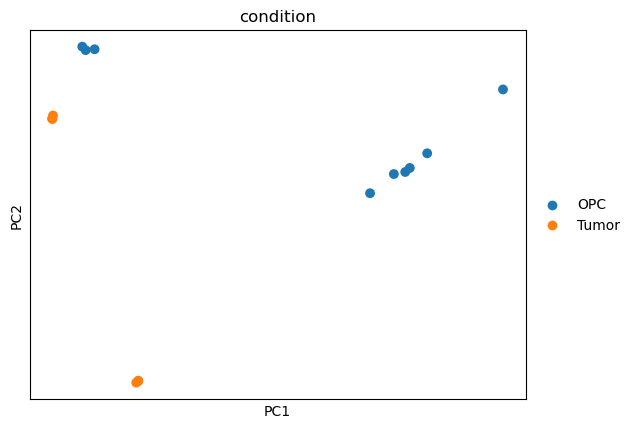

In [181]:
dds, de, fig = do_pseudobulk(adata, 'cell_type', 'OPC')

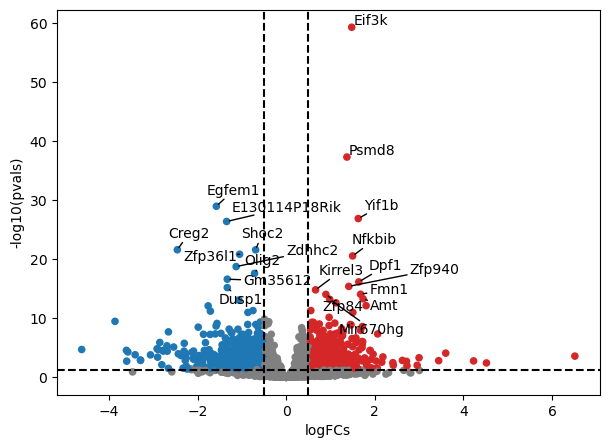

In [182]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20)

In [192]:
db['geneset'] = db['geneset'].apply(
    lambda x: x.split('_', 1)[1] if isinstance(x, str) and '_' in x else x
)

top_genes = de[de['padj'] < 0.05]

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,6,0.333333,0.138086,0.488634,3.443113,6.816956,Aldh1l2;Mthfd1
1,2FE_2S_CLUSTER_ASSEMBLY,9,0.111111,0.655873,0.836466,1.412644,0.595836,Fdx2
2,2_OXOGLUTARATE_METABOLIC_PROCESS,15,0.133333,0.511986,0.770716,1.443236,0.966187,Got2;Gpt2
3,3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_...,9,0.111111,0.655873,0.836466,1.412644,0.595836,Tpst1
4,3_UTR_MEDIATED_MRNA_DESTABILIZATION,13,0.153846,0.435332,0.745349,1.657215,1.378215,Zfp36l1;Zfp36l2


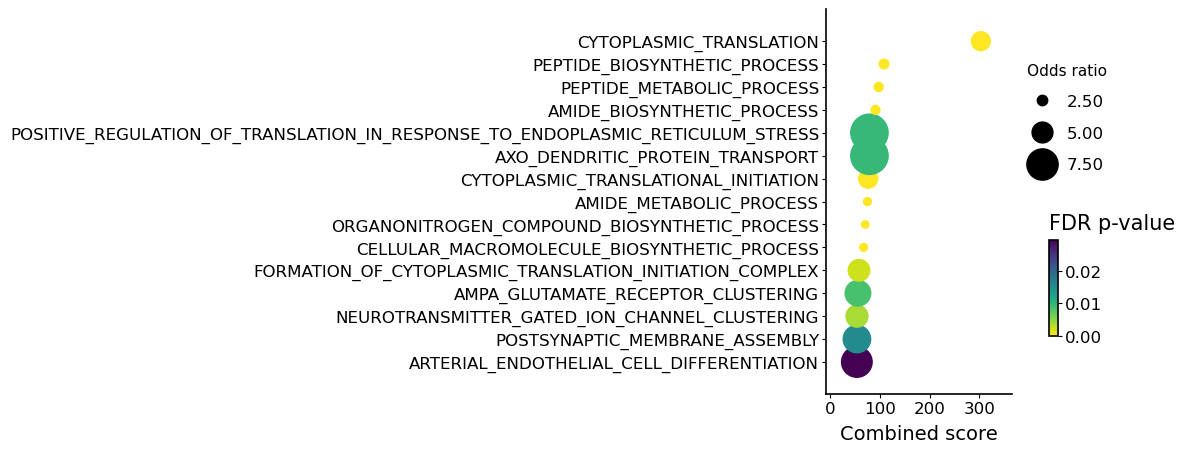

In [193]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
    )
    plt.grid(False)


## PEA

In [194]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

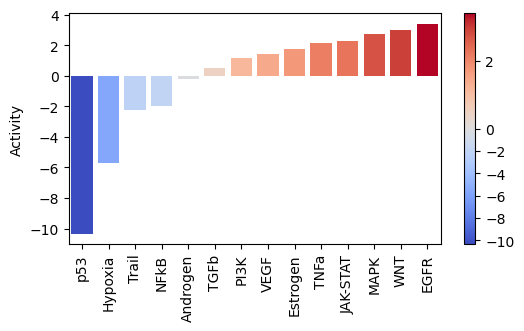

In [195]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

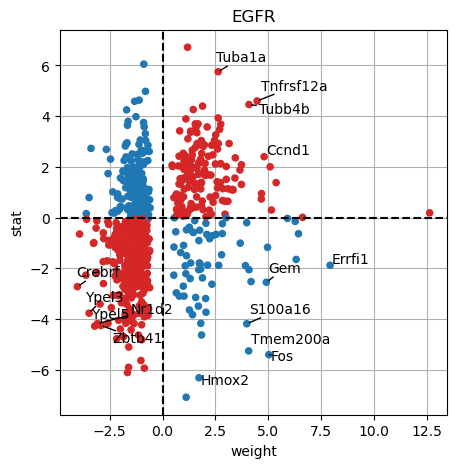

In [196]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='EGFR',
    net=progeny,
    top=15
)

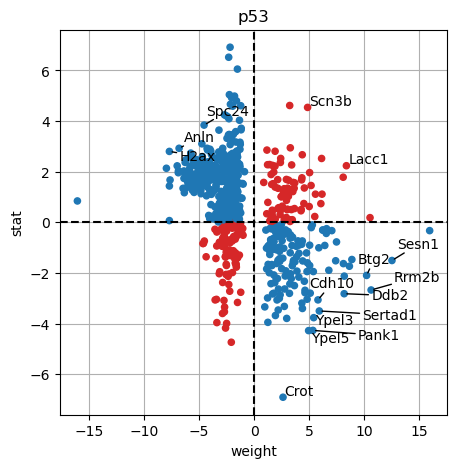

In [197]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='p53',
    net=progeny,
    top=15
)

In [ ]:
adata.obs['condition'] = adata.obs['sample_id'].apply(lambda x: 'Tumor' if x.startswith('Mouse') else 'Normal')

In [ ]:
adata.obs.condition = adata.obs.condition.astype('category')

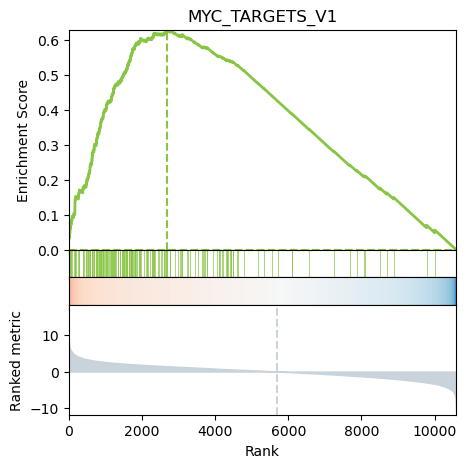

In [78]:
dc.plot_running_score(
    df=de,
    stat='stat',
    net=hm,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)

- old method

In [102]:
geneset_size = hm.groupby('geneset').size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

t_stats = sigs[['stat']].copy()
t_stats.rename(columns = {'stat': 'scores'}, inplace = True)

scores, norm, pvals = dc.run_gsea(t_stats.T, hm[hm.geneset.isin(gsea_genesets)], source = 'geneset', target='genesymbol', seed = seed, times = 100000, min_n = 15)

gsea_results = pd.concat({"score" : scores.T, "norm" : norm.T, "pval" : pvals.T}, axis = 1).droplevel(1, axis = 1).sort_values('pval')
epsilon = np.finfo(float).tiny  # Or use 1e-308
gsea_results['-log10(pval)'] = -np.log10(gsea_results.pval + epsilon)

In [104]:
pvals.T.sort_values(by='scores')

,scores
source,
G2M_CHECKPOINT,0.000000
E2F_TARGETS,0.000000
MYC_TARGETS_V1,0.000000
MITOTIC_SPINDLE,0.000000
OXIDATIVE_PHOSPHORYLATION,0.000000
MTORC1_SIGNALING,0.000000
MYC_TARGETS_V2,0.000000
UNFOLDED_PROTEIN_RESPONSE,0.000000
INTERFERON_GAMMA_RESPONSE,0.000594


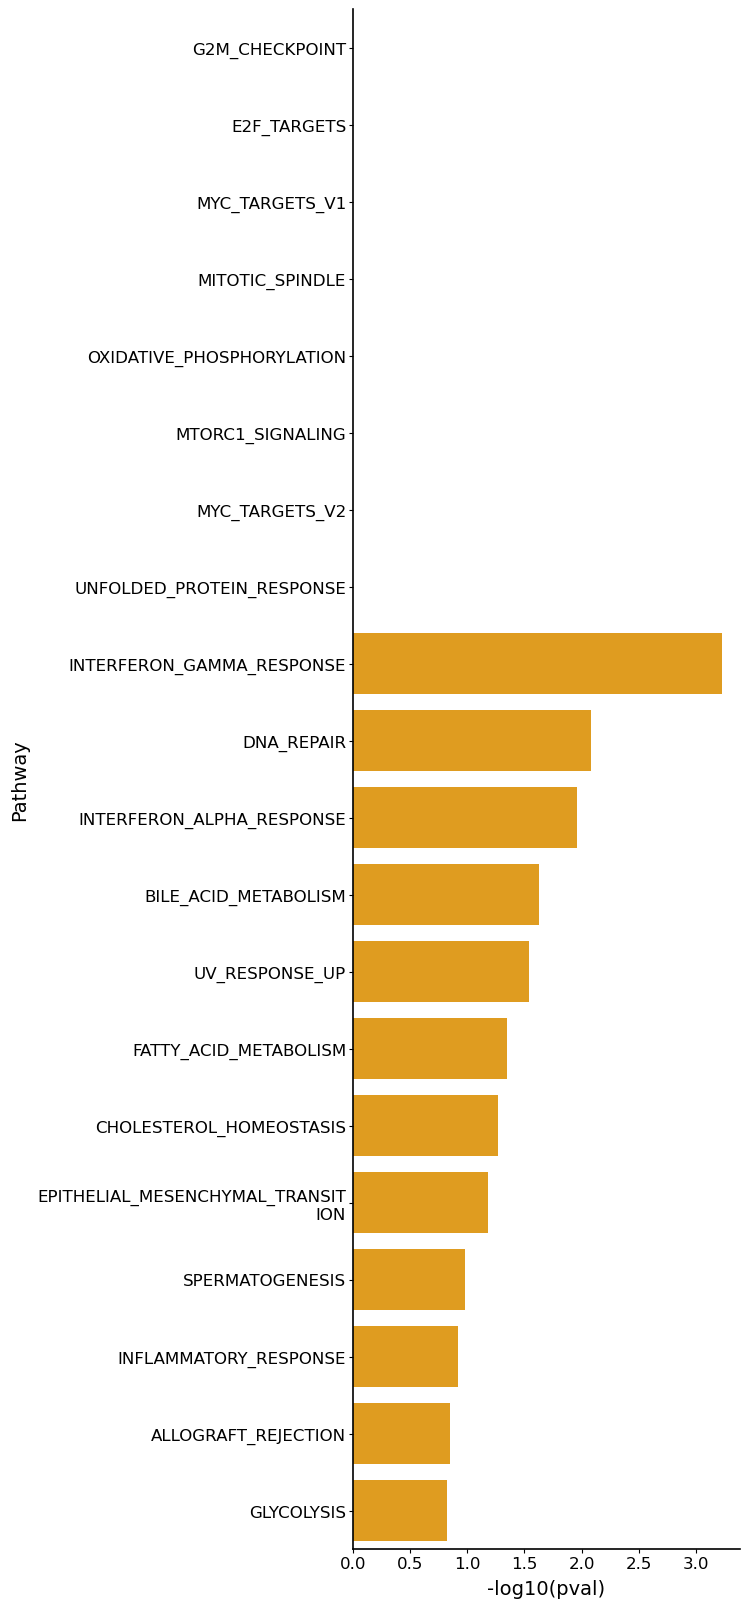

In [103]:
import textwrap

def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_yticklabels()]
    ax.set_yticklabels(labels, rotation=0, ha='right')

with mplscience.style_context():
    plt.figure(figsize = (5, 20))
    ax = sns.barplot(gsea_results.head(20), x = '-log10(pval)', y = gsea_results.head(20).index, color = 'orange')
    wrap_labels(ax, 30)
    plt.xlabel('-log10(pval)')
    plt.ylabel('Pathway')
    plt.show()